In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

In [4]:
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
atlas

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57233.312022,17.869,0.140,258.0,36.0,o,0,1.48,263.90117,50.41108,7946.34,859.24,3.56,3.48,54.5,-0.492,18.56,19.52,02a57233o0057o
1,57233.371685,18.040,0.149,221.0,33.0,o,0,1.72,263.90117,50.41108,6402.88,2308.24,3.51,3.39,-82.1,-0.453,18.52,19.43,02a57233o0099o
2,57233.386618,17.993,0.162,230.0,37.0,o,0,0.98,263.90117,50.41108,6393.67,2314.11,3.50,3.35,-80.3,-0.454,18.50,19.39,02a57233o0109o
3,57234.332653,17.976,0.192,234.0,45.0,o,0,1.22,263.90117,50.41108,7938.61,863.54,3.93,3.74,2.2,-0.484,18.30,19.16,02a57234o0036o
4,57234.369895,18.073,0.217,214.0,46.0,o,0,1.04,263.90117,50.41108,6396.39,2305.21,3.69,3.47,-81.8,-0.475,18.29,19.10,02a57234o0064o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2663,60100.437571,17.155,0.054,499.0,27.0,o,0,1.24,263.90117,50.41108,7882.66,9065.14,2.34,2.25,55.3,-0.440,18.86,19.48,02a60100o0410o
2664,60100.442825,17.156,0.058,499.0,29.0,o,0,1.11,263.90117,50.41108,7861.65,9183.83,2.30,2.14,46.9,-0.442,18.93,19.47,02a60100o0421o
2665,60102.438539,17.195,0.038,481.0,18.0,o,0,1.12,263.90117,50.41108,4140.40,3125.71,2.38,2.01,37.3,-0.449,19.14,20.03,02a60102o0418o
2666,60102.439895,17.155,0.034,499.0,17.0,o,0,1.68,263.90117,50.41108,4163.12,3165.74,2.26,1.93,38.4,-0.455,19.21,20.03,02a60102o0421o


In [5]:
oband = atlas[atlas['f']=='o']
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57233.312022,17.869,0.140,258.0,36.0,o,0,1.48,263.90117,50.41108,7946.34,859.24,3.56,3.48,54.5,-0.492,18.56,19.52,02a57233o0057o
1,57233.371685,18.040,0.149,221.0,33.0,o,0,1.72,263.90117,50.41108,6402.88,2308.24,3.51,3.39,-82.1,-0.453,18.52,19.43,02a57233o0099o
2,57233.386618,17.993,0.162,230.0,37.0,o,0,0.98,263.90117,50.41108,6393.67,2314.11,3.50,3.35,-80.3,-0.454,18.50,19.39,02a57233o0109o
3,57234.332653,17.976,0.192,234.0,45.0,o,0,1.22,263.90117,50.41108,7938.61,863.54,3.93,3.74,2.2,-0.484,18.30,19.16,02a57234o0036o
4,57234.369895,18.073,0.217,214.0,46.0,o,0,1.04,263.90117,50.41108,6396.39,2305.21,3.69,3.47,-81.8,-0.475,18.29,19.10,02a57234o0064o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2663,60100.437571,17.155,0.054,499.0,27.0,o,0,1.24,263.90117,50.41108,7882.66,9065.14,2.34,2.25,55.3,-0.440,18.86,19.48,02a60100o0410o
2664,60100.442825,17.156,0.058,499.0,29.0,o,0,1.11,263.90117,50.41108,7861.65,9183.83,2.30,2.14,46.9,-0.442,18.93,19.47,02a60100o0421o
2665,60102.438539,17.195,0.038,481.0,18.0,o,0,1.12,263.90117,50.41108,4140.40,3125.71,2.38,2.01,37.3,-0.449,19.14,20.03,02a60102o0418o
2666,60102.439895,17.155,0.034,499.0,17.0,o,0,1.68,263.90117,50.41108,4163.12,3165.74,2.26,1.93,38.4,-0.455,19.21,20.03,02a60102o0421o


In [6]:
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57233.312022,17.869,0.140,258.0,36.0,o,0,1.48,263.90117,50.41108,7946.34,859.24,3.56,3.48,54.5,-0.492,18.56,19.52,02a57233o0057o
1,57233.371685,18.040,0.149,221.0,33.0,o,0,1.72,263.90117,50.41108,6402.88,2308.24,3.51,3.39,-82.1,-0.453,18.52,19.43,02a57233o0099o
2,57233.386618,17.993,0.162,230.0,37.0,o,0,0.98,263.90117,50.41108,6393.67,2314.11,3.50,3.35,-80.3,-0.454,18.50,19.39,02a57233o0109o
3,57234.332653,17.976,0.192,234.0,45.0,o,0,1.22,263.90117,50.41108,7938.61,863.54,3.93,3.74,2.2,-0.484,18.30,19.16,02a57234o0036o
4,57234.369895,18.073,0.217,214.0,46.0,o,0,1.04,263.90117,50.41108,6396.39,2305.21,3.69,3.47,-81.8,-0.475,18.29,19.10,02a57234o0064o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,60100.437571,17.155,0.054,499.0,27.0,o,0,1.24,263.90117,50.41108,7882.66,9065.14,2.34,2.25,55.3,-0.440,18.86,19.48,02a60100o0410o
2056,60100.442825,17.156,0.058,499.0,29.0,o,0,1.11,263.90117,50.41108,7861.65,9183.83,2.30,2.14,46.9,-0.442,18.93,19.47,02a60100o0421o
2057,60102.438539,17.195,0.038,481.0,18.0,o,0,1.12,263.90117,50.41108,4140.40,3125.71,2.38,2.01,37.3,-0.449,19.14,20.03,02a60102o0418o
2058,60102.439895,17.155,0.034,499.0,17.0,o,0,1.68,263.90117,50.41108,4163.12,3165.74,2.26,1.93,38.4,-0.455,19.21,20.03,02a60102o0421o


In [7]:
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
    # this keeps the first entry, I'd love if it took an average
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57233.312022,17.869,0.140,258.0,36.0,o,0,1.48,263.90117,50.41108,7946.34,859.24,3.56,3.48,54.5,-0.492,18.56,19.52,02a57233o0057o
1,57233.371685,18.040,0.149,221.0,33.0,o,0,1.72,263.90117,50.41108,6402.88,2308.24,3.51,3.39,-82.1,-0.453,18.52,19.43,02a57233o0099o
2,57233.386618,17.993,0.162,230.0,37.0,o,0,0.98,263.90117,50.41108,6393.67,2314.11,3.50,3.35,-80.3,-0.454,18.50,19.39,02a57233o0109o
3,57234.332653,17.976,0.192,234.0,45.0,o,0,1.22,263.90117,50.41108,7938.61,863.54,3.93,3.74,2.2,-0.484,18.30,19.16,02a57234o0036o
4,57234.369895,18.073,0.217,214.0,46.0,o,0,1.04,263.90117,50.41108,6396.39,2305.21,3.69,3.47,-81.8,-0.475,18.29,19.10,02a57234o0064o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,60100.437571,17.155,0.054,499.0,27.0,o,0,1.24,263.90117,50.41108,7882.66,9065.14,2.34,2.25,55.3,-0.440,18.86,19.48,02a60100o0410o
2056,60100.442825,17.156,0.058,499.0,29.0,o,0,1.11,263.90117,50.41108,7861.65,9183.83,2.30,2.14,46.9,-0.442,18.93,19.47,02a60100o0421o
2057,60102.438539,17.195,0.038,481.0,18.0,o,0,1.12,263.90117,50.41108,4140.40,3125.71,2.38,2.01,37.3,-0.449,19.14,20.03,02a60102o0418o
2058,60102.439895,17.155,0.034,499.0,17.0,o,0,1.68,263.90117,50.41108,4163.12,3165.74,2.26,1.93,38.4,-0.455,19.21,20.03,02a60102o0421o


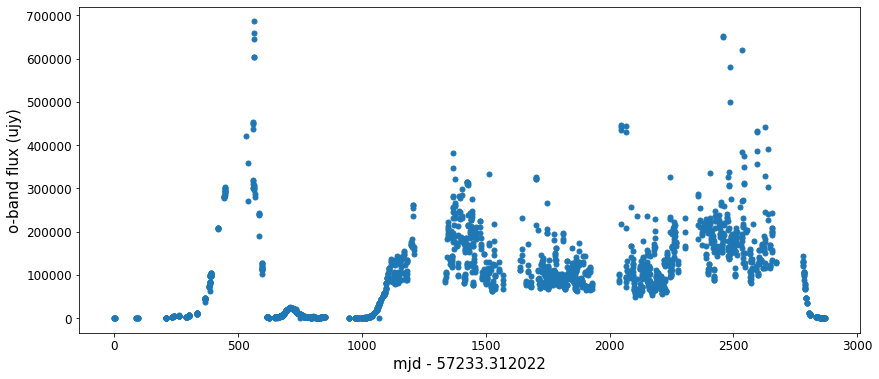

In [61]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['ujy'])#/(80000),s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band flux (ujy)')
# plt.ylim(top=1.2)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

In [9]:
median_filtered = sp.signal.medfilt(oband['m'],kernel_size=5)

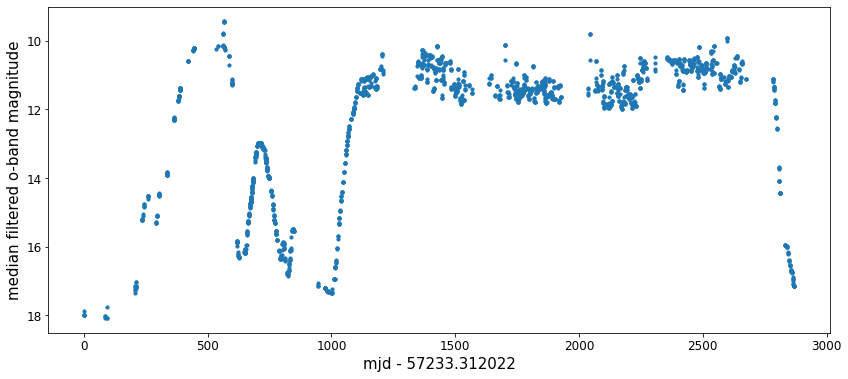

In [10]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
plt.show()

In [11]:
smoothed_flux = convolve(oband['m'], Gaussian1DKernel(20),boundary='extend')

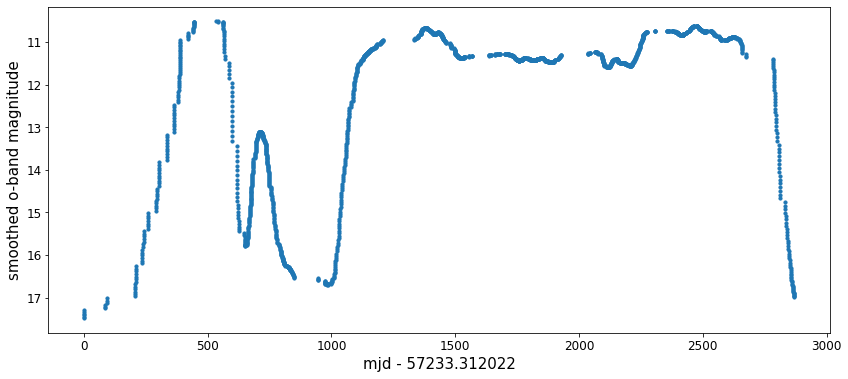

In [12]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],smoothed_flux,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('smoothed o-band magnitude')
plt.show()

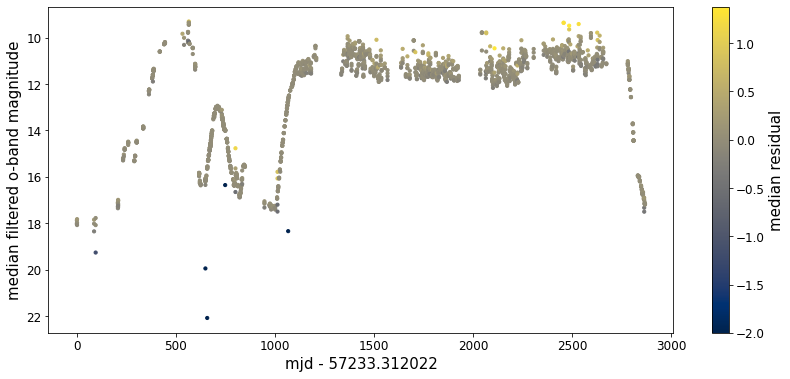

In [13]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
            c=median_filtered-oband['m'],cmap='cividis')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='median residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

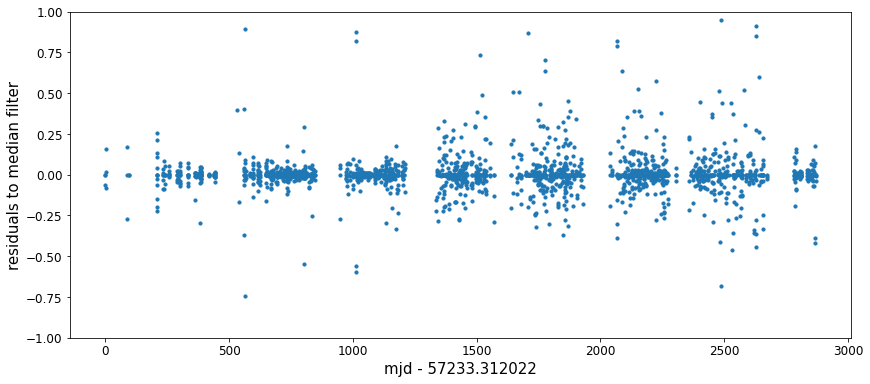

In [14]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered-oband['m'],s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to median filter')
plt.ylim(-1,1)
plt.show()

In [15]:
mask = np.where(np.abs(median_filtered-oband['m'])<0.25,True,False)
mask

array([ True,  True,  True, ...,  True,  True,  True])

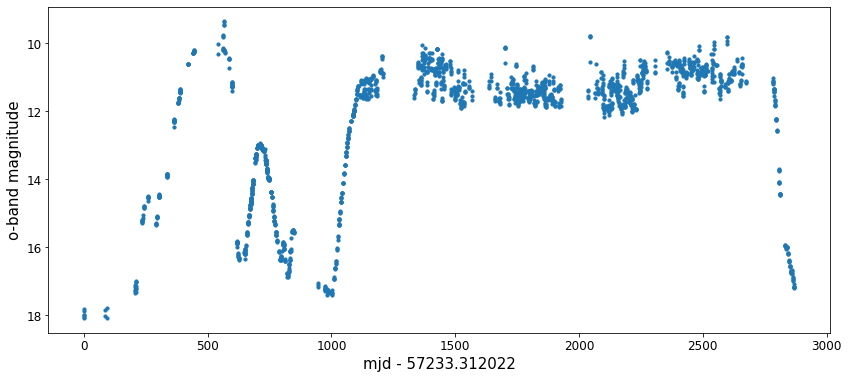

In [16]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd'][mask]-oband['mjd'][0],oband['m'][mask],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.show()

In [17]:
median_filtered_oband = oband.iloc[mask]
median_filtered_oband.reset_index(drop=True,inplace=True)
median_filtered_oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57233.312022,17.869,0.140,258.0,36.0,o,0,1.48,263.90117,50.41108,7946.34,859.24,3.56,3.48,54.5,-0.492,18.56,19.52,02a57233o0057o
1,57233.371685,18.040,0.149,221.0,33.0,o,0,1.72,263.90117,50.41108,6402.88,2308.24,3.51,3.39,-82.1,-0.453,18.52,19.43,02a57233o0099o
2,57233.386618,17.993,0.162,230.0,37.0,o,0,0.98,263.90117,50.41108,6393.67,2314.11,3.50,3.35,-80.3,-0.454,18.50,19.39,02a57233o0109o
3,57234.332653,17.976,0.192,234.0,45.0,o,0,1.22,263.90117,50.41108,7938.61,863.54,3.93,3.74,2.2,-0.484,18.30,19.16,02a57234o0036o
4,57234.369895,18.073,0.217,214.0,46.0,o,0,1.04,263.90117,50.41108,6396.39,2305.21,3.69,3.47,-81.8,-0.475,18.29,19.10,02a57234o0064o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,60100.437571,17.155,0.054,499.0,27.0,o,0,1.24,263.90117,50.41108,7882.66,9065.14,2.34,2.25,55.3,-0.440,18.86,19.48,02a60100o0410o
1943,60100.442825,17.156,0.058,499.0,29.0,o,0,1.11,263.90117,50.41108,7861.65,9183.83,2.30,2.14,46.9,-0.442,18.93,19.47,02a60100o0421o
1944,60102.438539,17.195,0.038,481.0,18.0,o,0,1.12,263.90117,50.41108,4140.40,3125.71,2.38,2.01,37.3,-0.449,19.14,20.03,02a60102o0418o
1945,60102.439895,17.155,0.034,499.0,17.0,o,0,1.68,263.90117,50.41108,4163.12,3165.74,2.26,1.93,38.4,-0.455,19.21,20.03,02a60102o0421o


In [18]:
# edge_detect = sp.ndimage.convolve(oband['m'][mask], CustomKernel([1.0, 0.0, -1.0]))
edge_detect = sp.ndimage.convolve(median_filtered_oband['m'], [1.0, 0.0, -1.0])

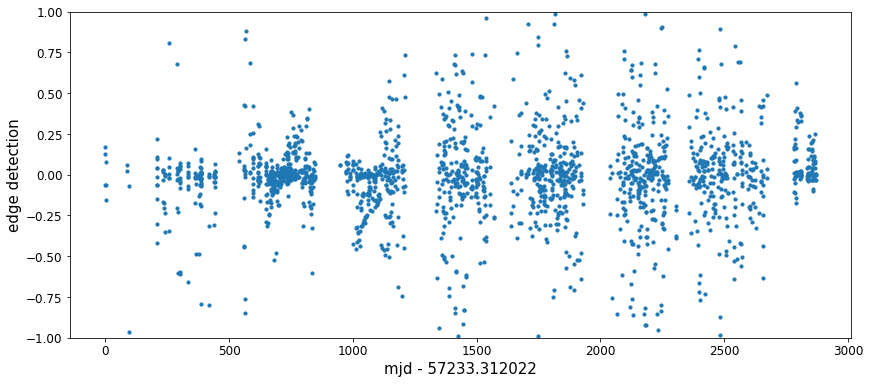

In [19]:
mjd_scale = median_filtered_oband['mjd'][0]

plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('edge detection')
plt.ylim(-1,1)
plt.show()

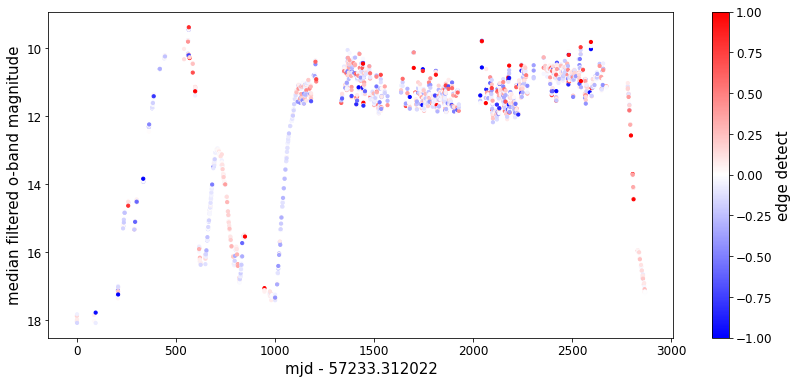

In [20]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
            c=edge_detect,cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-1,1)
plt.show()

### added in a gaussian smooth before the interpolation here

In [21]:
smoothed_flux = convolve(median_filtered_oband['m'], Gaussian1DKernel(20),boundary='extend')

# interpolation_function = sp.interpolate.interp1d(np.asarray(median_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(median_filtered_oband['m']),
#                                                  kind='slinear')
interpolation_function = sp.interpolate.interp1d(np.asarray(median_filtered_oband['mjd']-mjd_scale),
                                                 np.asarray(smoothed_flux),
                                                 kind='slinear')
## what time resolution? I don't want to lose any of the real data if possible
real_resolution = np.median(np.diff(median_filtered_oband['mjd']))
len_data = np.max(median_filtered_oband['mjd']-mjd_scale)
resample_time = np.linspace(0,len_data,int(len_data))#int(len_data/(real_resolution/10000)))
## currently resampling at a resolution of 1 day
resample_flux = interpolation_function(resample_time)

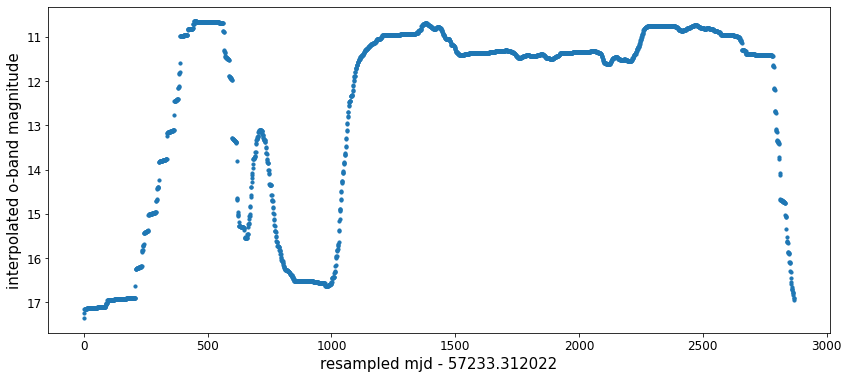

In [22]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.show()

In [23]:
new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])

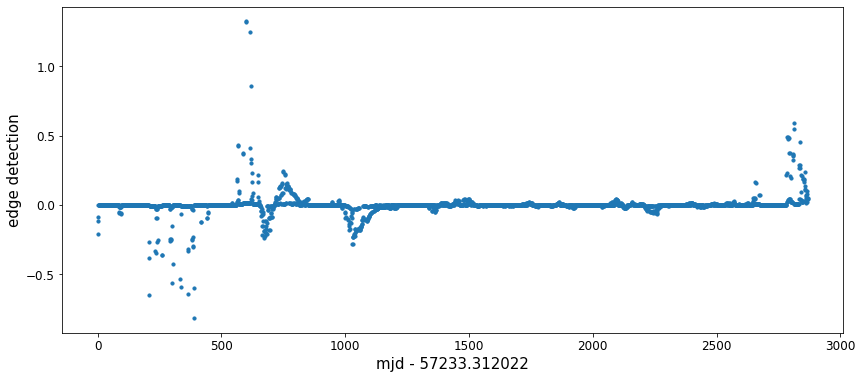

In [24]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,new_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
# plt.ylim(-1,1)
plt.show()

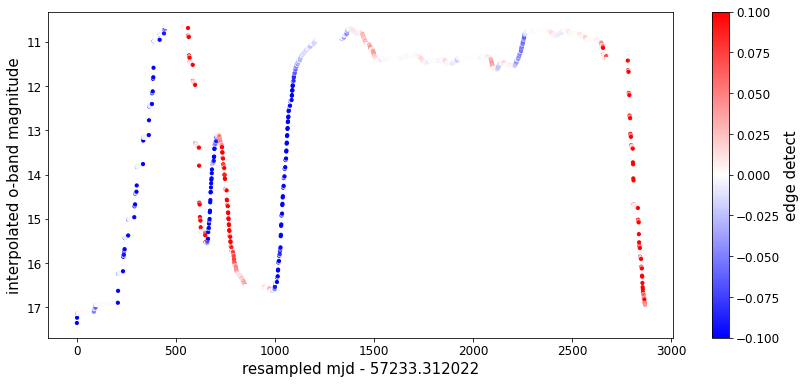

In [25]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

# Actually all the GP stuff should go here :)

In [26]:
kernel = Matern(length_scale=3, nu=3/2) + WhiteKernel(noise_level=1) #+ ConstantKernel()
# kernel = RBF(length_scale=1,length_scale_bounds=(1e-05, 10)) + WhiteKernel(noise_level=1) #+ ConstantKernel()

In [27]:
# median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m']

time = np.asarray(median_filtered_oband['mjd']-mjd_scale)
time = time.reshape(-1,1)

In [28]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(time, median_filtered_oband['m'])
# GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
#                 kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
#                 n_restarts_optimizer=0, normalize_y=False,
#                 optimizer='fmin_l_bfgs_b', random_state=None)

GaussianProcessRegressor(kernel=Matern(length_scale=3, nu=1.5) + WhiteKernel(noise_level=1))

In [29]:
gp.kernel_

Matern(length_scale=127, nu=1.5) + WhiteKernel(noise_level=0.0622)

### big question: what resolution should I resample to?

Probably once a night is fine, RCBs shouldn't vary much more than that??

In [30]:
x_pred = np.linspace(0, int(np.max(time))+1, int(np.max(time))+1).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

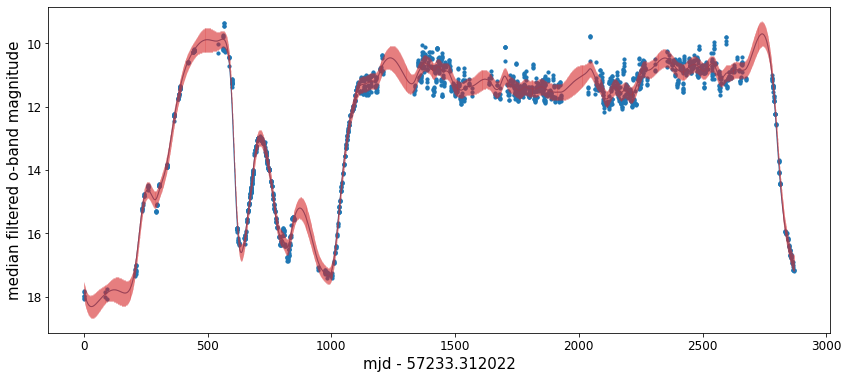

In [31]:
plt.figure(figsize=(14,6))

plt.plot(x_pred,y_pred)#+12)
plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
# plt.xlim(1000,3000)
plt.show()

In [32]:
gpsmoothed_time = time
gpsmoothed_flux, gpsigma = gp.predict(gpsmoothed_time, return_std=True)

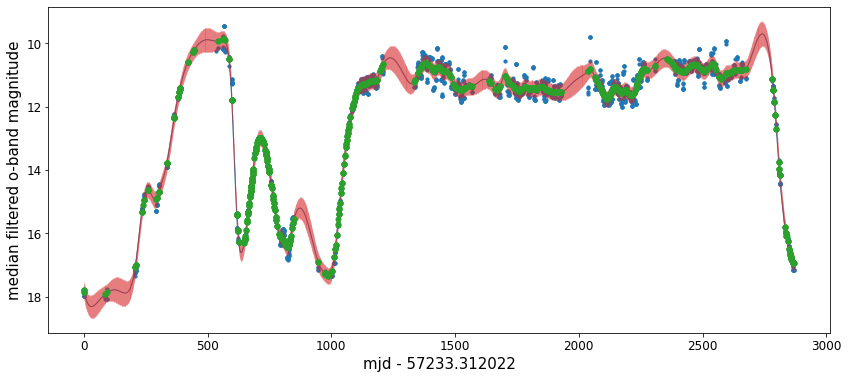

In [33]:
plt.figure(figsize=(14,6))

plt.plot(x_pred,y_pred)
plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

plt.scatter(gpsmoothed_time,gpsmoothed_flux,color='tab:green',zorder=3)

plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
# plt.xlim(1000,3000)
plt.show()

In [34]:
gp_edge_detect = sp.ndimage.convolve(y_pred, [1.0, 0.0, -1.0])

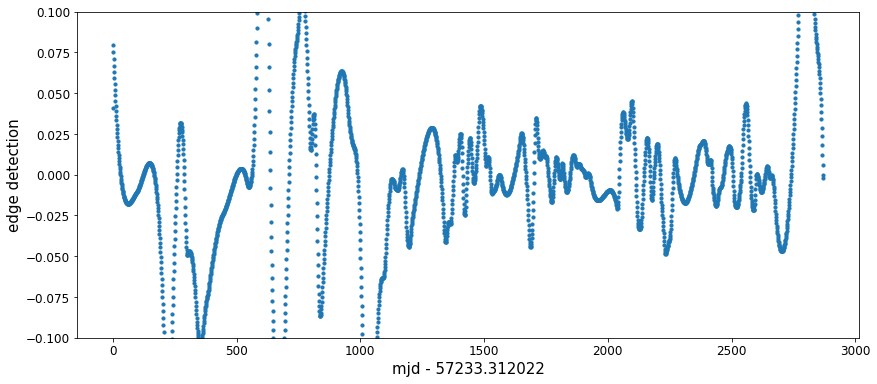

In [35]:
# np.std()

plt.figure(figsize=(14,6))
plt.scatter(x_pred,gp_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
plt.ylim(-0.1,0.1)
plt.show()

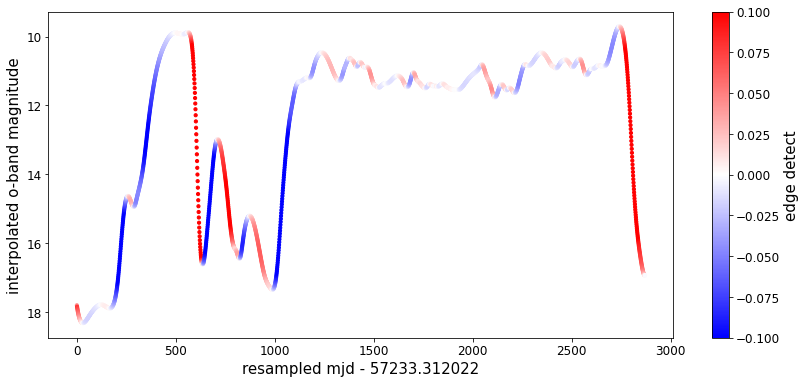

In [36]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(x_pred,y_pred,s=10,
            c=gp_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

In [37]:
## interpolate the edge detection to convert back to the original times
# np.linspace(0, int(np.max(time)), int(np.max(time)))
gp_edgedetect_interp = sp.interpolate.interp1d(x_pred[:,0],
                                                 gp_edge_detect,
                                                 kind='slinear')

gp_edges = gp_edgedetect_interp(median_filtered_oband['mjd']-mjd_scale)

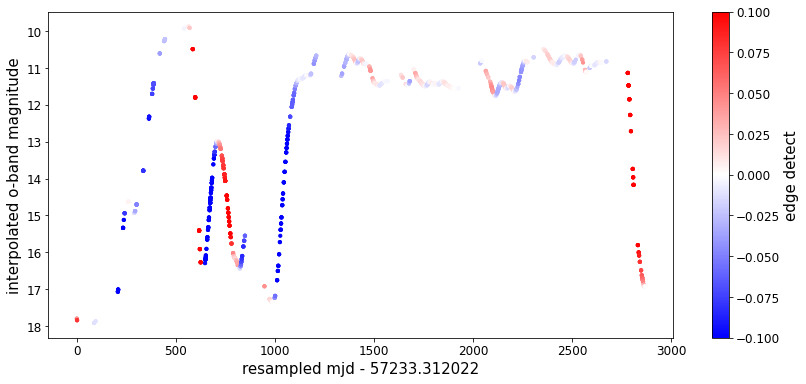

In [38]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(gpsmoothed_time,gpsmoothed_flux,s=10,
            c=gp_edges,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

# Now back to normal

In [39]:
## interpolate the edge detection to convert back to the original times
# edge_detect_interp_func = sp.interpolate.interp1d(resample_time,
#                                                  new_edge_detect,
#                                                  kind='slinear')

# edges_realdata = edge_detect_interp_func(median_filtered_oband['mjd']-mjd_scale)


In [40]:
# plt.figure(figsize=(14,6))
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,edges_realdata,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('edge detect back to real data')
# # plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# # plt.clim(-1,1)
# plt.show()

In [41]:
# plt.figure(figsize=(14,6))
# # plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(edges_realdata+3)*4,s=10)
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
#             c=(edges_realdata),cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('median filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # plt.xlim(950,1200)
# # plt.xlim(500,1000)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

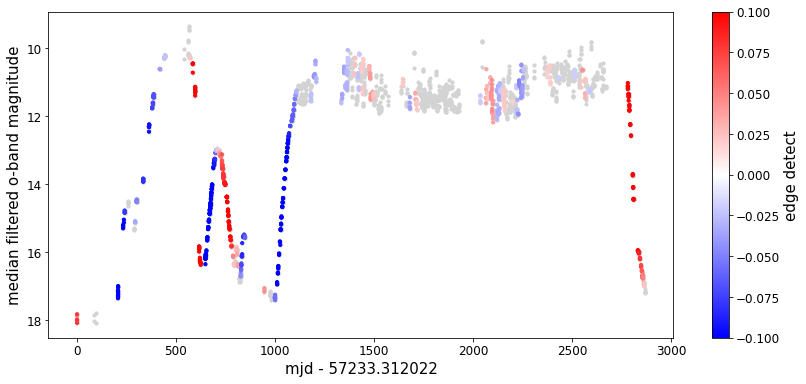

In [42]:
std_dev = np.std(gp_edges)
# std_dev
new_mask = np.where(np.abs(gp_edges)>(std_dev*0.25),True,False)

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd'][new_mask]-mjd_scale,median_filtered_oband['m'][new_mask],s=10,
            c=(gp_edges[new_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

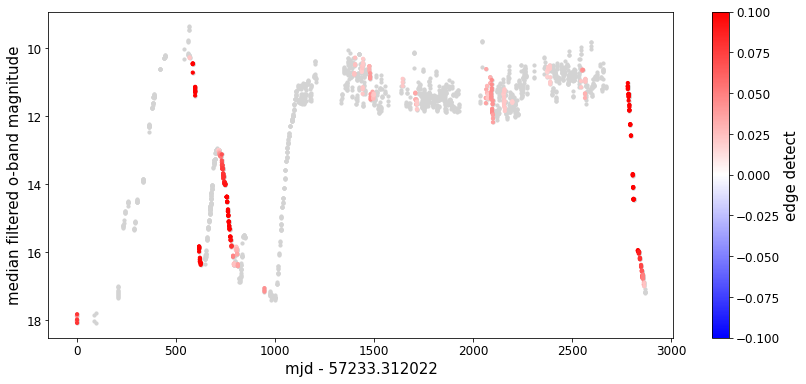

In [43]:
std_dev = np.std(gp_edges)
new_mask = np.where(np.abs(gp_edges)>(std_dev*0.25),True,False)
downslope_mask = np.where(gp_edges>0.0,True,False)
total_mask = new_mask & downslope_mask

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd'][total_mask]-mjd_scale,median_filtered_oband['m'][total_mask],s=10,
            c=(gp_edges[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [44]:
print(median_filtered_oband['mjd'][total_mask]-mjd_scale)

0          0.000000
1          0.059663
2          0.074596
3          1.020631
4          1.057873
           ...     
1935    2863.089768
1936    2863.096804
1937    2863.100369
1938    2865.142889
1939    2865.169397
Name: mjd, Length: 446, dtype: float64


In [45]:
def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

In [46]:
run_vals, run_start, run_length = find_runs(total_mask)

In [47]:
downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

In [48]:
median_filtered_oband['mjd'][downward_mask]-mjd_scale

0          0.000000
151      569.335589
340      716.114031
483      802.934714
863     1401.131827
916     1438.981037
955     1477.003513
1059    1709.273744
1334    2065.285477
1433    2155.112685
1498    2199.044977
1606    2375.311389
1773    2546.100388
1854    2782.292400
Name: mjd, dtype: float64

In [49]:
median_filtered_oband['mjd'][run_start]

0       57233.312022
6       57320.210339
151     57802.647611
194     57880.597779
340     57949.426053
478     58030.255560
483     58036.246736
503     58054.231153
542     58180.642451
545     58206.575149
863     58634.443849
870     58642.469112
916     58672.293059
932     58680.375483
955     58710.315535
977     58734.258965
1036    58878.581481
1039    58894.602416
1059    58942.585766
1070    58956.584858
1334    59298.597499
1373    59342.481094
1433    59388.424707
1452    59398.411264
1498    59432.356999
1502    59436.339616
1606    59608.623411
1622    59629.586404
1773    59779.412410
1786    59803.366735
1854    60015.604422
1940    60100.432121
Name: mjd, dtype: float64

In [50]:
median_filtered_oband['m'][run_start]

0       17.869
6       18.013
151     10.282
194     16.145
340     13.019
478     16.254
483     15.929
503     16.747
542     17.050
545     17.215
863     10.743
870     10.790
916     10.693
932     11.596
955     10.596
977     11.667
1036    10.993
1039    11.693
1059    11.298
1070    11.309
1334    11.608
1373    11.843
1433    11.363
1452    11.374
1498    11.552
1502    11.717
1606    10.685
1622    10.634
1773    10.960
1786    11.371
1854    11.103
1940    17.081
Name: m, dtype: float64

In [51]:
decline_onset = []
decline_end = []
for i in range(0,len(median_filtered_oband['m'][run_start])):
    if i == 0 and np.abs(median_filtered_oband['m'].iloc[0] - median_filtered_oband['m'][run_start[i+1]]) > 0.8:
        ## adding the absolute magnitude should detect beginning declines
        ## NEEDS TO BE TESTED
        decline_onset.append(0)
        print('beginning')
        print('0')
        print(median_filtered_oband['mjd'][0])
        print(np.abs(median_filtered_oband['m'].iloc[0] - median_filtered_oband['m'][run_start[i]]))
    elif i == len(median_filtered_oband['m'][run_start])-1:
        if median_filtered_oband['m'].iloc[-1] - median_filtered_oband['m'][run_start[i]] > 0.8:
            decline_onset.append(run_start[i])
            print('end')
            print(run_start[i])
            print(median_filtered_oband['mjd'][run_start[i]])
            print(median_filtered_oband['m'].iloc[-1] - median_filtered_oband['m'][run_start[i]])
    elif median_filtered_oband['m'][run_start[i+1]] - median_filtered_oband['m'][run_start[i]] > 0.8:#1:
        decline_onset.append(run_start[i])
        print(run_start[i])
        print(median_filtered_oband['mjd'][run_start[i]])
        print(median_filtered_oband['m'][run_start[i+1]] - median_filtered_oband['m'][run_start[i]])
#     if i == len(median_filtered_oband['m'][run_start]):
#         print('end')

151
57802.647611
5.8629999999999995
340
57949.426053
3.235000000000001
483
58036.246736
0.8179999999999996
916
58672.293059
0.9030000000000005
955
58710.315535
1.0709999999999997
1854
60015.604422
5.978


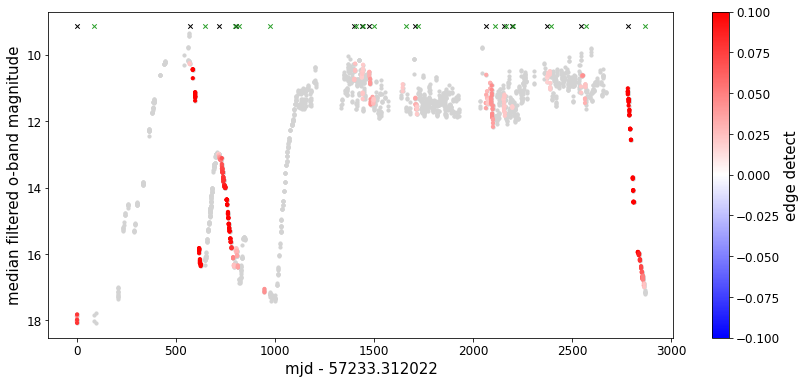

In [52]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd'][downward_mask]-mjd_scale,
            np.full(len(median_filtered_oband['mjd'][downward_mask]),np.min(median_filtered_oband['m']))-0.2
                    ,s=20,marker='x',color='k',zorder=3)
plt.scatter(median_filtered_oband['mjd'][upward_mask]-mjd_scale,
            np.full(len(median_filtered_oband['mjd'][upward_mask]),np.min(median_filtered_oband['m']))-0.2
                    ,s=20,marker='x',color='tab:green',zorder=3)
# plt.scatter(median_filtered_oband['mjd'][decline_onset]-mjd_scale,
#             np.full(len(median_filtered_oband['mjd'][decline_onset]),np.min(median_filtered_oband['m']))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
plt.scatter(median_filtered_oband['mjd'][total_mask]-mjd_scale,median_filtered_oband['m'][total_mask],s=10,
            c=(gp_edges[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
plt.show()

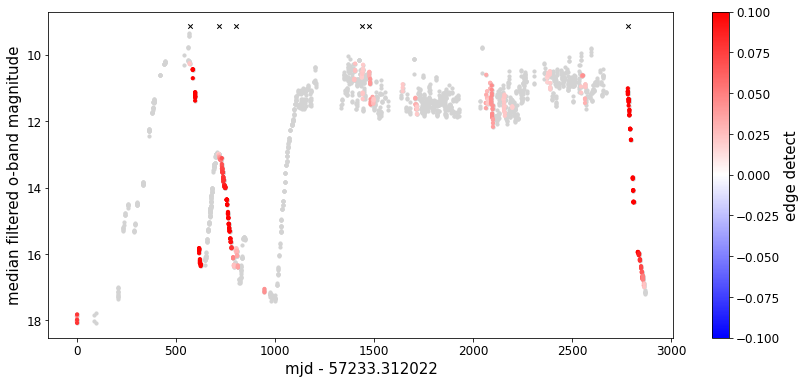

In [53]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(median_filtered_oband['mjd'][downward_mask]-mjd_scale,
#             np.full(len(median_filtered_oband['mjd'][downward_mask]),np.min(median_filtered_oband['m']))-0.2
#                     ,s=20,marker='x',color='k',zorder=3)
# plt.scatter(median_filtered_oband['mjd'][upward_mask]-mjd_scale,
#             np.full(len(median_filtered_oband['mjd'][upward_mask]),np.min(median_filtered_oband['m']))-0.2
#                     ,s=20,marker='x',color='tab:green',zorder=3)
plt.scatter(median_filtered_oband['mjd'][decline_onset]-mjd_scale,
            np.full(len(median_filtered_oband['mjd'][decline_onset]),np.min(median_filtered_oband['m']))-0.2,
                    s=20,marker='x',color='k',zorder=3)
plt.scatter(median_filtered_oband['mjd'][total_mask]-mjd_scale,median_filtered_oband['m'][total_mask],s=10,
            c=(gp_edges[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()

In [54]:
# https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data

def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

In [55]:
savgol_filtered = non_uniform_savgol(np.asarray(median_filtered_oband['mjd']-mjd_scale),
                                     np.asarray(median_filtered_oband['m']),
                                   window=7, polynom=1)

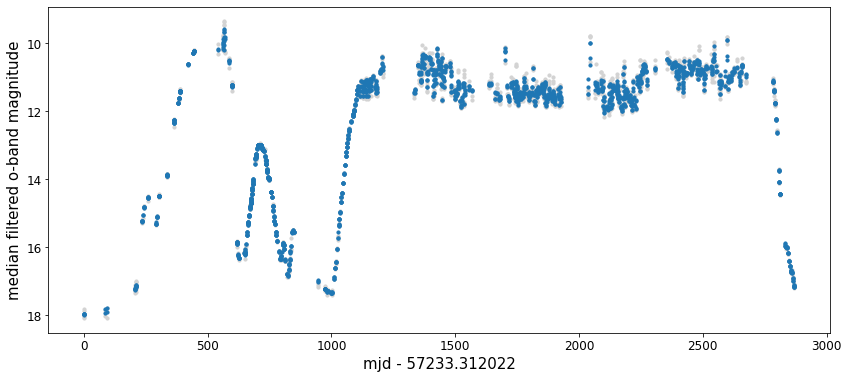

In [56]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd']-mjd_scale,savgol_filtered,s=10)#,color='lightgrey')


plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
# plt.xlim(1200,1500)
plt.show()

In [57]:
# ## thinking about a sliding sigma detection to mask out the point if the std dev is too big (esp at max)

# def generate_saturation_mask(x,y,window_days,stddev_limit):
    

In [59]:
# median_filtered_oband['mjd']-mjd_scale,savgol_filtered
time = median_filtered_oband['mjd']-mjd_scale

stddev_arr = []

half_window=3
for i in range(5,len(time)-5):
    window_mask = np.where(np.abs(time-time[i])<half_window)
    print(np.std(savgol_filtered[window_mask]))
#     stddev_arr.append(np.std)

0.0068239100108601295
0.06477705931665056
0.06477705931665056
0.06307357182218709
0.06307357182218709
0.050075299552281426
0.050075299552281426
0.050075299552281426
0.050075299552281426
0.050075299552281426
0.050075299552281426
0.050075299552281426
0.050075299552281426
0.050075299552281426
0.050075299552281426
0.050075299552281426
0.050075299552281426
0.006234242575992766
0.006234242575992766
0.006234242575992766
0.006234242575992766
0.006234242575992766
0.006234242575992766
0.0005253074958382342
0.0005253074958382342
0.019383048140499456
0.019383048140499456
0.019383048140499456
0.019383048140499456
0.019383048140499456
0.010657083033078517
0.010657083033078517
0.010657083033078517
0.010657083033078517
0.010657083033078517
0.010657083033078517
0.010657083033078517
0.019882201798088688
0.019882201798088688
0.019882201798088688
0.019882201798088688
0.019882201798088688
0.004615460189644239
0.004615460189644239
0.004615460189644239
0.004615460189644239
0.004615460189644239
0.005588474319

0.24421118065606406
0.22890681077248784
0.22890681077248784
0.22890681077248784
0.22890681077248784
0.23100383791098447
0.23100383791098447
0.23100383791098447
0.23100383791098447
0.23686541017578122
0.23686541017578122
0.23686541017578122
0.23686541017578122
0.20997605668616523
0.20997605668616523
0.20997605668616523
0.20997605668616523
0.14310249129442806
0.14310249129442806
0.14310249129442806
0.14310249129442806
0.15578249789241885
0.15578249789241885
0.15578249789241885
0.15578249789241885
0.1859853997778508
0.1859853997778508
0.1859853997778508
0.007972261209656354
0.007972261209656354
0.007972261209656354
0.007972261209656354
0.013533173590144663
0.013533173590144663
0.013533173590144663
0.013533173590144663
0.1100675508891349
0.1100675508891349
0.1100675508891349
0.1100675508891349
0.0977720218868729
0.0977720218868729
0.0977720218868729
0.0977720218868729
0.0977720218868729
0.0977720218868729
0.0977720218868729
0.15444670876434227
0.15444670876434227
0.15444670876434227
0.1381